### A single-cell survey of the small intestinal epithelium: ***in vivo*** reference data

In [6]:
%matplotlib inline

import os
import helper_functions_GSE164638 as hf

import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.io
import scipy.sparse as ssp
import matplotlib.pyplot as plt

<div class="alert alert-info">
    
# Navigating this notebook
*** ***    
    
    
##### Data used in this notebook is from the following publication: 
    
Haber AL, Biton M, Rogel N, et al. A single-cell survey of the small intestinal epithelium. Nature. 2017;551(7680):333-339. [doi:10.1038/nature24489.](https://pubmed.ncbi.nlm.nih.gov/29144463/)

*** ***
    
##### Data can be downloaded from:
    
[GEO:GSE92332](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92332)
    
*** ***    
**Set settings and load data**
0. [Directories](#step0)
1. [Load data](#load_data)
    <br>
    <br>
    
**Filtering: mitochondrial, ribosomal, ncRNA gene high cells**
2. [Filtering cells based on mitochondrial gene expression](#mito_filter)
3. [Filtering cells based on ribosomal gene expression](#ribo_filter)
4. [Summary of # barcodes (cells) pre-filter and post-filter](#bc_summary)
    <br>
    <br>

**Preprocessing for visualization**
5. [Preprocessing: normalization, logarithmizing, choosing highly variable genes](#pp_norm_log_hvg) 
6. [Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, cluster, and visualize](#pp_z_score_log_pca_leiden_umap)
    <br>
    <br>
    
**Annotating cell states**
7. [Classify cells based on marker gene scores](#annotation)
8. [Coarse grain classifaction based on cluster consensus](#coarse_grain)
    <br>
    <br>
    
**Save files**
9. [Save data files](#save_all) 
10. [Export to SPRING](#spring) 
    
</div>  

*** ***

<a id='step0'></a>

## Directories

In [7]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)


# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_preprocessing'
os.makedirs(plot_dir, exist_ok=True)

qc_dir = '_plots_filter_QC'
os.makedirs(qc_dir, exist_ok=True)


# for SPRING plots:
spring_main='_spring'
os.makedirs(spring_main, exist_ok=True)

In [8]:
input_paths = {
    '_sc_data/counts/GSE92332/': ['GSM2839445_Atlas1', 
                                'GSM2839446_Atlas2', 
                                'GSM2839447_Atlas5', 
                                'GSM2839448_Atlas6', 
                                'GSM2839449_Atlas9',
                                'GSM2839450_Atlas10',
                                'GSM2839451_SH_Control_Rep1',
                                'GSM2839452_SH_Control_Rep2',
                                'GSM2839453_SH_Control_Rep3',
                                'GSM2839454_SH_Control_Rep4']
}

# `meta_keys` lists the names of the columns to be added to the .obs dataframe.
# For each key in `meta_keys`, there must be a corresponding entry in the 
# `meta_values` list for each sample.
# Use key 'new name' if you want to convert the original sample IDs into more
# meaningful sample names.
meta_keys = ['sample', 'replicate', 'condition', 'tissue']
meta_values = {'Atlas1': ['Atlas', '1', 'WT', 'all'],
               'Atlas2': ['Atlas', '2', 'WT', 'all'],
               'Atlas5': ['Atlas', '5', 'WT', 'all'],
               'Atlas6': ['Atlas', '6', 'WT', 'all'],
               'Atlas9': ['Atlas', '9', 'WT', 'all'],
               'Atlas10': ['Atlas', '10', 'WT', 'all'],
               'SH_Control_Rep1': ['SH', '1', 'Ctrl', 'all'],
               'SH_Control_Rep2': ['SH', '2', 'Ctrl', 'all'],
               'SH_Control_Rep3': ['SH', '3', 'Ctrl', 'all'],
               'SH_Control_Rep4': ['SH', '4', 'Ctrl', 'all']}

### Set up export formatting for scanpy figures

In [9]:
# look for the folder "figures"
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                     frameon=True, vector_friendly=True, fontsize=14, 
                     figsize=None, color_map=None, format='eps', 
                     facecolor=None, transparent=False, ipython_format='png2x')

<a id='load_data'></a>

## Load data and save 

In [10]:
D = {}
os.makedirs(h5ad_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

for iFold, folder in enumerate(input_paths):
    for mtx_fname in input_paths[folder]:
        h5ad_filename = f'{h5ad_dir}/{mtx_fname}-raw.h5ad'
        if os.path.exists(h5ad_filename):
            D[mtx_fname] = sc.read(h5ad_filename)
        else:
            X = scipy.io.mmread(f'{folder}/{mtx_fname}_matrix.mtx.gz')
            barcodes = np.loadtxt(f'{folder}/{mtx_fname}_barcodes.tsv.gz', dtype=str)
            genes = np.loadtxt(f'{folder}/{mtx_fname}_genes.tsv.gz', dtype=str)
            
            var_names = []
            for gene in list(genes[:, 1]):
                if gene.startswith('mm10_'):
                    gene = gene.strip('mm10_')
                else:
                    gene = gene
                var_names.append(gene)
            
            D[mtx_fname] = sc.AnnData((X.transpose()).tocsr())
            D[mtx_fname].obs_names = barcodes
            D[mtx_fname].var_names = var_names
            D[mtx_fname].var_names_make_unique()
            D[mtx_fname].obs['n_counts'] = D[mtx_fname].X.sum(1).A.squeeze()
            
            D[mtx_fname].write_h5ad(h5ad_filename, compression='gzip', force_dense=True)

        print('Loaded {}: {} barcodes, {} genes'.format(mtx_fname, *D[mtx_fname].shape))

Loaded GSM2839445_Atlas1: 1518 barcodes, 27775 genes
Loaded GSM2839446_Atlas2: 1642 barcodes, 27775 genes
Loaded GSM2839447_Atlas5: 463 barcodes, 27775 genes
Loaded GSM2839448_Atlas6: 141 barcodes, 27775 genes
Loaded GSM2839449_Atlas9: 944 barcodes, 27775 genes
Loaded GSM2839450_Atlas10: 509 barcodes, 27775 genes
Loaded GSM2839451_SH_Control_Rep1: 961 barcodes, 27775 genes
Loaded GSM2839452_SH_Control_Rep2: 239 barcodes, 27775 genes
Loaded GSM2839453_SH_Control_Rep3: 1397 barcodes, 27775 genes
Loaded GSM2839454_SH_Control_Rep4: 1068 barcodes, 27775 genes


In [11]:
# To load the filtered files at a later point:
sample_list = ['GSM2839445_Atlas1', 
               'GSM2839446_Atlas2', 
               'GSM2839447_Atlas5', 
               'GSM2839448_Atlas6', 
               'GSM2839449_Atlas9',
               'GSM2839450_Atlas10',
               'GSM2839451_SH_Control_Rep1',
               'GSM2839452_SH_Control_Rep2',
               'GSM2839453_SH_Control_Rep3',
               'GSM2839454_SH_Control_Rep4']

D = {}
for s in sample_list:
    D[s] = sc.read(f'{h5ad_dir}/{s}-raw.h5ad')

In [12]:
# merge the libraries into one AnnData object
adata = sc.AnnData.concatenate(
    *[D[s] for s in sample_list], 
    batch_key='Library Name',
    batch_categories=sample_list
)

In [13]:
def gene_list_lowercase(adata):
    adata_gene_lower = []
    for gene_name in adata.var_names:
        gene_name = gene_name.lower()
        adata_gene_lower.append(gene_name)
    adata.var_names = adata_gene_lower

In [14]:
# keep all genes lowercase
# keep in mind for loading lists of genes later on
gene_list_lowercase(adata)

In [15]:
# 8882 cells x 27775 genes (already filtered!)
adata.X.shape

(8882, 27775)

In [16]:
# use scanpy's quality control metrics and store in AnnData object for later reference
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [17]:
# write as an AnnData file to recover before preprocessing if you ever need it
sc.write(f'{h5ad_dir}/adata_raw_reference_subset_GSE92332.h5ad', adata)

<a id='mito_filter'></a>

## Filtering cells based on mitochondrial gene expression 

In [18]:
# define mitochondrial genes
mito_genes = adata.var_names.str.startswith(("mt-"))
print(sum(mito_genes))

13


In [19]:
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add % mitochondrial genes per cell to .obs DataFrame in AnnData object
adata.obs['percent_mito'] = np.sum(
    ssp.csc_matrix(adata[:, mito_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

# add the total counts per cell to .obs DataFrame in AnnData object
adata.obs['n_counts'] = ssp.csc_matrix(adata.X).sum(axis=1).A1

#sense-check
print(len(adata.var_names[mito_genes]))

13


### Plot fraction of UMIs belonging to mitochondrial genes for cells in dataset

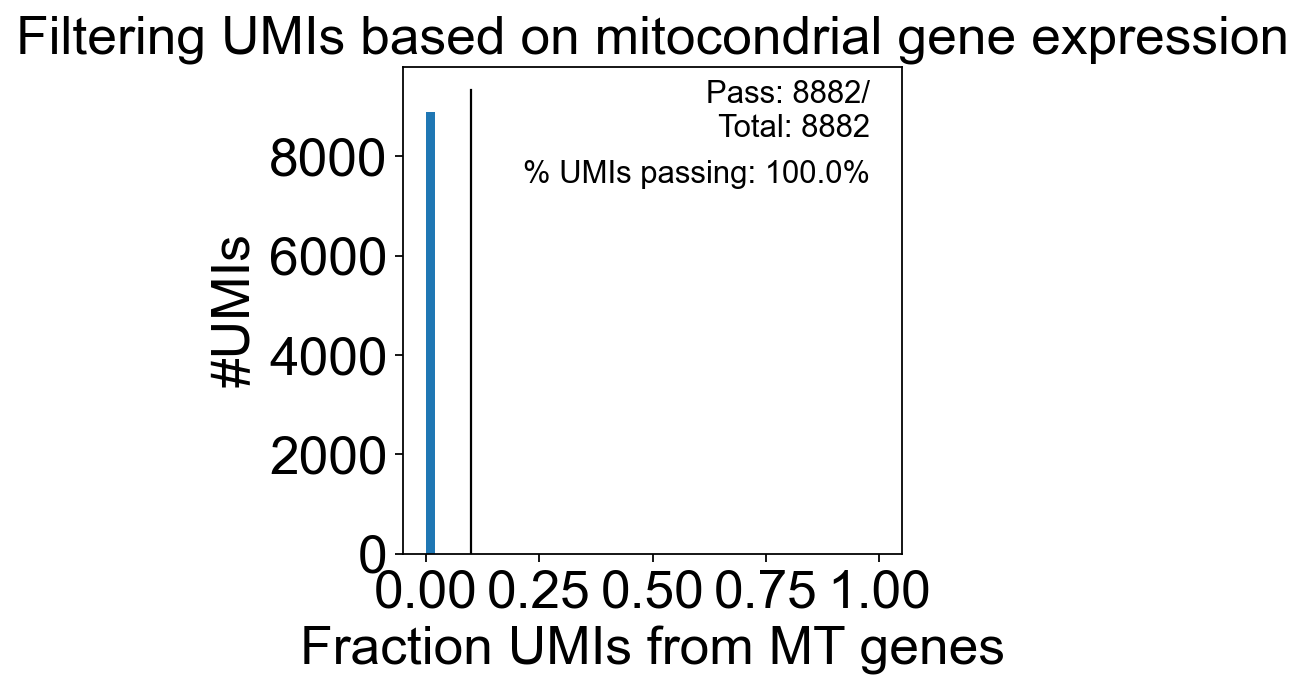

<Figure size 320x320 with 0 Axes>

In [20]:
# max fraction of UMIs coming from mitochondrial genes
max_mt = 0.1

adata.obs['mito_frac'] = adata.X[:, mito_genes].sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['mito_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_mt,max_mt], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['mito_frac'])
npass = sum(adata.obs['mito_frac'] <= max_mt)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=14, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=14, ha='right')

plt.title('Filtering UMIs based on mitocondrial gene expression', fontsize='24')
plt.xlabel('Fraction UMIs from MT genes', fontsize='24')
plt.ylabel('#UMIs', fontsize='24')
plt.xticks(fontsize='24')
plt.yticks(fontsize='24')

plt.show()
plt.show()

plt.tight_layout()
plt.savefig(f'{qc_dir}/umis_passing_after_mito_{max_mt}_reference_subset_GSE92332.eps')

<a id='ribo_filter'></a>

## Filtering cells based on ribosomal genes

In [21]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("rps","rpl", "malat1"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    ssp.csc_matrix(adata[:, ribo_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

114


### Plot fraction of UMIs belonging to ribosomal genes for all cells

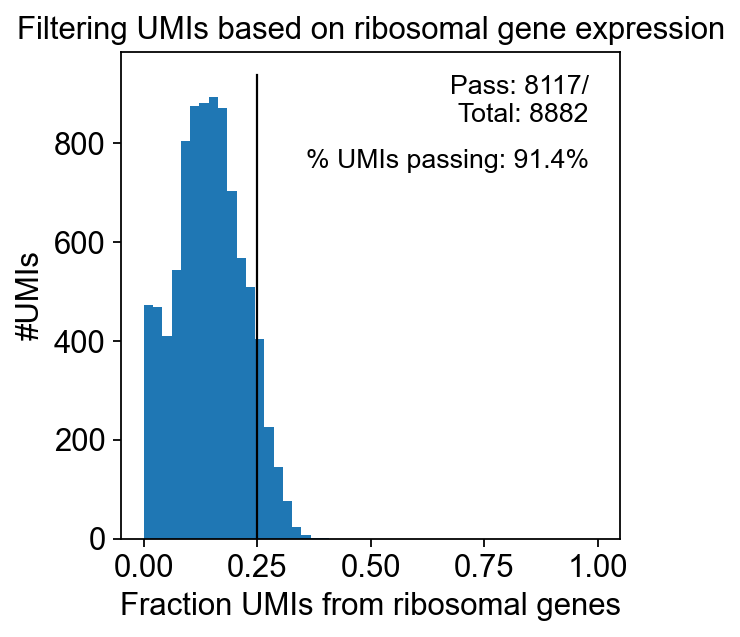

<Figure size 320x320 with 0 Axes>

In [22]:
# max fraction of UMIs coming from ribosomal genes
max_ribo = 0.25

adata.obs['ribo_frac'] = adata.X[:,ribo_genes].sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['ribo_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_ribo,max_ribo], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['ribo_frac'])
npass = sum(adata.obs['ribo_frac'] <= max_ribo)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on ribosomal gene expression')
plt.xlabel('Fraction UMIs from ribosomal genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_ribo_{max_ribo}_reference_subset_GSE92332.eps')

In [23]:
pct_ribo = {}
for lib_name in adata.obs['Library Name'].unique():
    pct_ribo[lib_name] = np.around(adata.obs.loc[adata.obs['Library Name'] == lib_name]['percent_ribo'].median()*100, 2)

### Plot all three metrics as violin plots for visualizing across libraries

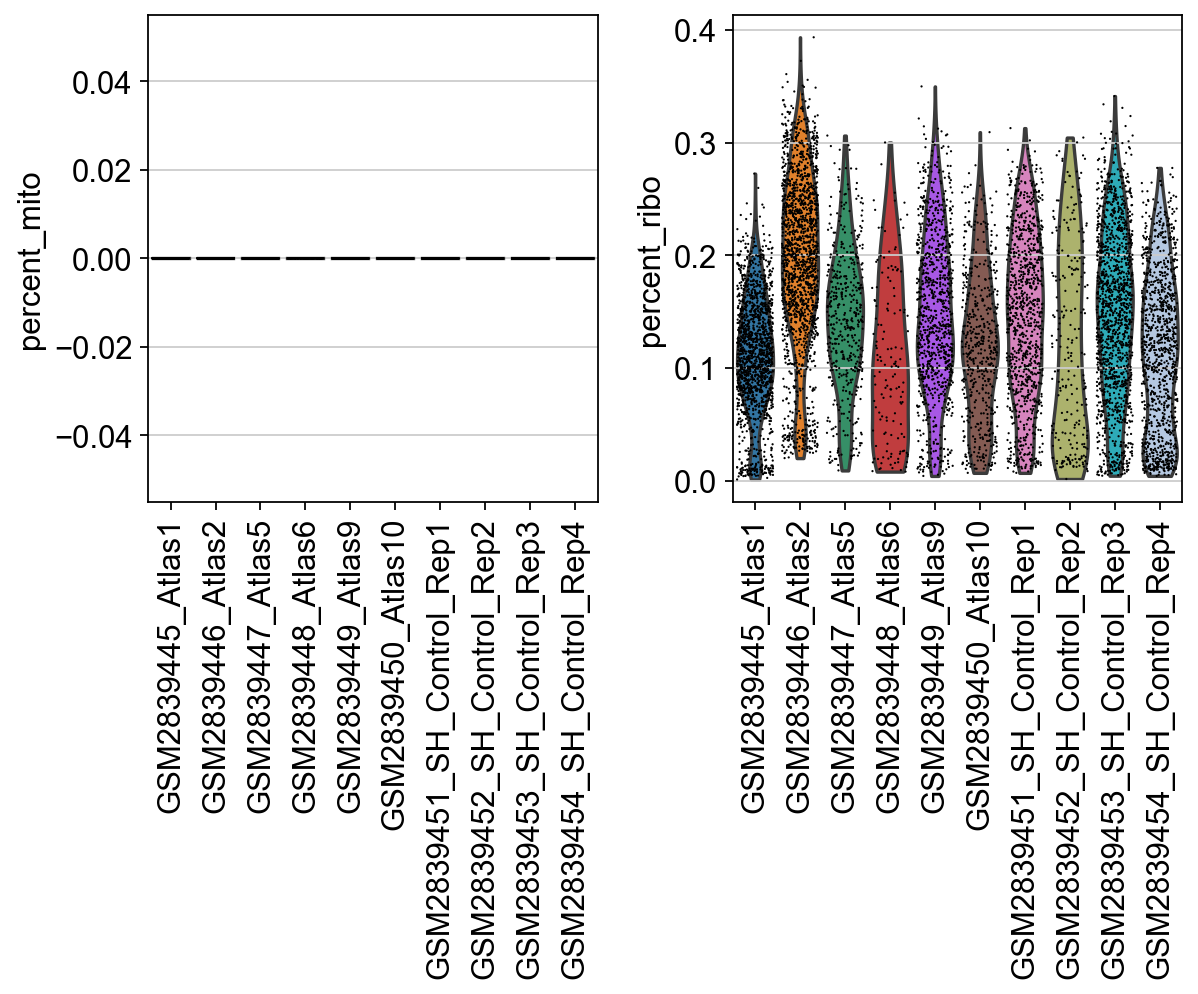

In [24]:
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],
             jitter=0.4, groupby = 'Library Name', rotation=90, save='_reference_subset_GSE92332_after_mito_filter')

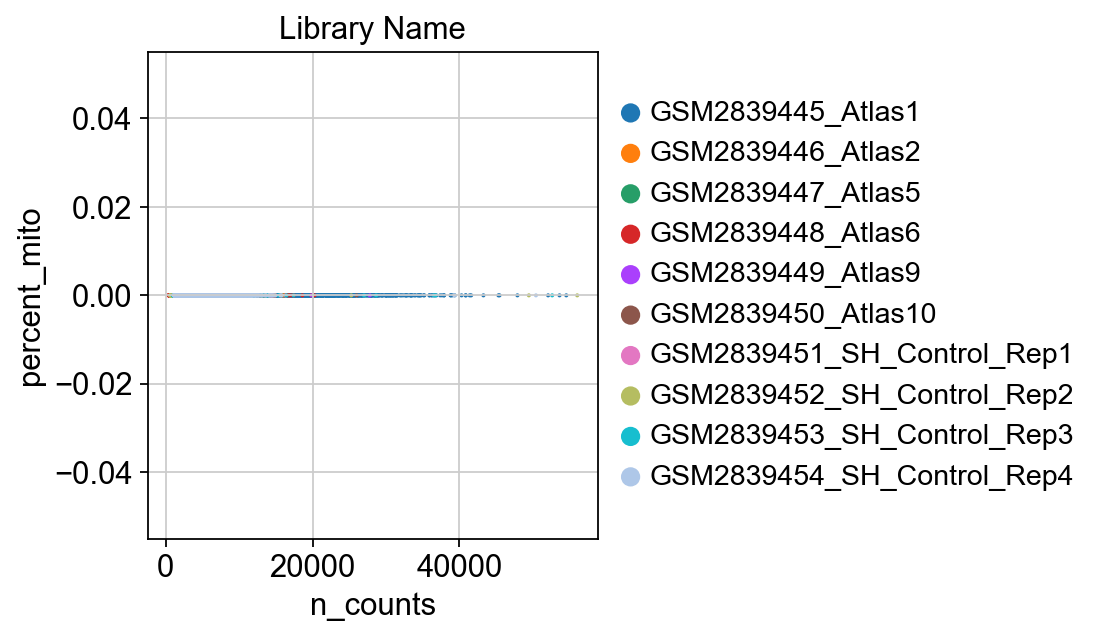

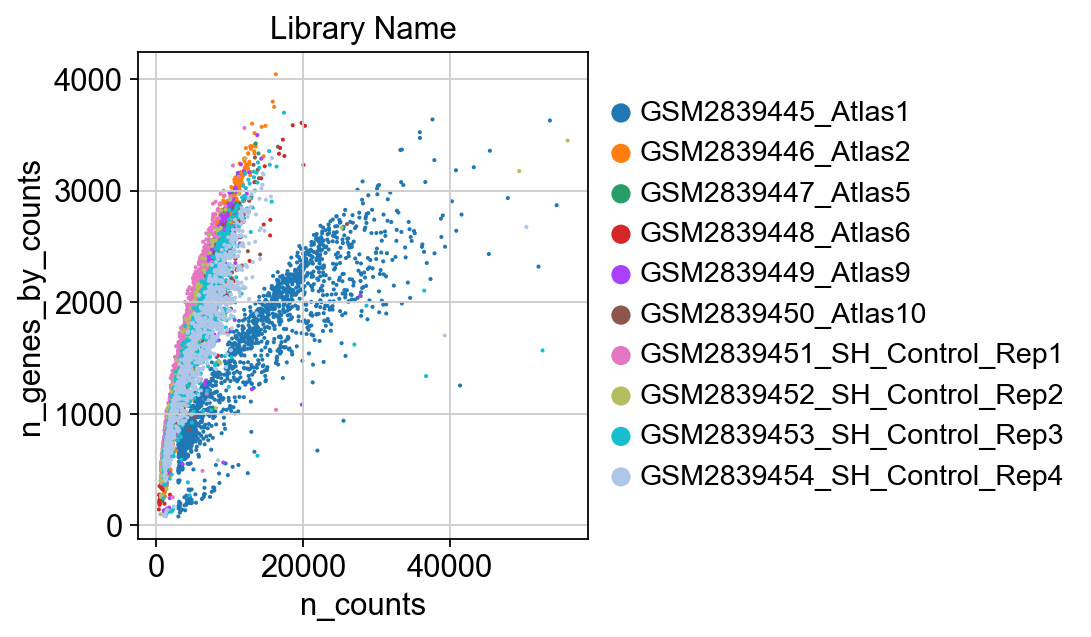

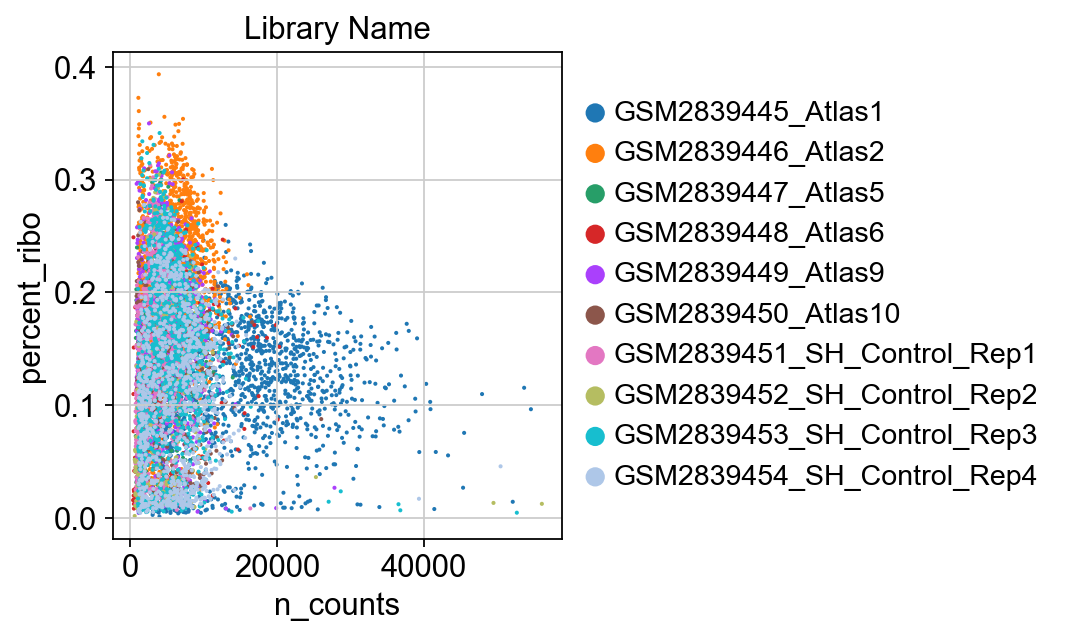

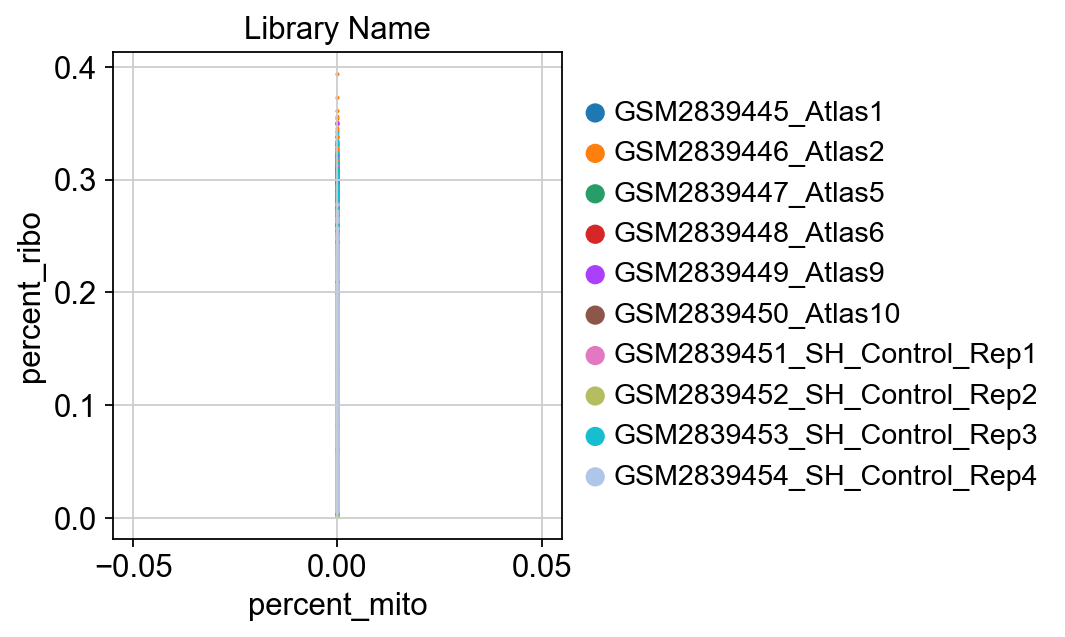

In [25]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="Library Name", save='pct_mito_reference_subset_GSE92332')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color="Library Name", save='genes_by_counts_reference_subset_GSE92332')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="Library Name", save='pct_ribo_reference_subset_GSE92332')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="Library Name", save='pct_ribo_v_pct_mito_reference_subset_GSE92332')

<a id='bc_summary'></a>

## Summary of # barcodes (cells) pre-filter and post-filter 

In [26]:
print('Sample\t\t\t# barcodes pre-filter\t\t# barcodes post-filter')

s = 'Merged'
n_orig = adata.shape[0]
adata = adata[adata.obs['mito_frac'] <= max_mt]
adata = adata[adata.obs['ribo_frac'] <= max_ribo]

# one more filtering step
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

n_pass = adata.shape[0]
print('{:20s}\t{}\t\t\t\t{}'.format(s, n_orig, n_pass))

Sample			# barcodes pre-filter		# barcodes post-filter


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Merged              	8882				8075


In [27]:
adata.raw = adata # save the filtered adata with the counts matrix untouched!!

*** ***

<a id='pp_norm_log_hvg'></a>

## Preprocessing: Normalization, logarithmizing, choosing highly variable genes

In [28]:
# Total count normalize to CP10K - this overwrites X!
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 

In [29]:
# sense check
print('before normalization:', adata.raw[1000].X.sum())
print('after normalization:', adata[1000].X.sum())

before normalization: 19554.0
after normalization: 10000.0


In [30]:
# log-transform the counts matrix
sc.pp.log1p(adata)

In [31]:
# calculate highly variable genes based on parameters below
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.5)

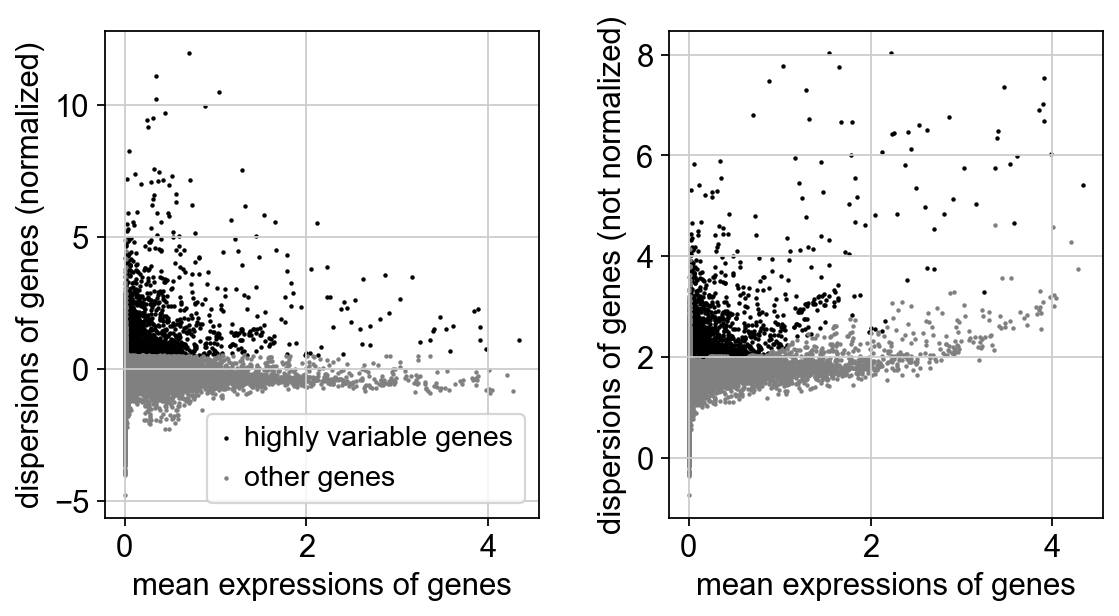

In [32]:
sc.pl.highly_variable_genes(adata)

In [33]:
len(adata.var.loc[adata.var['highly_variable'] == True])

2549

In [34]:
# lgr5 and lyz1 should make it onto this list - let's double-check
print('lgr5 highly variable?:', adata.var[adata.var.index == 'lgr5']['highly_variable'].values)
print('lyz1 highly variable?:', adata.var[adata.var.index == 'lyz1']['highly_variable'].values)

lgr5 highly variable?: [ True]
lyz1 highly variable?: [ True]


<a id='pp_z_score_log_pca_leiden_umap'></a>

## Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, cluster, and visualize

In [35]:
# z-score before running PCA
sc.pp.scale(adata, max_value=10)

In [36]:
# Run PCA
sc.pp.pca(adata, n_comps=20)

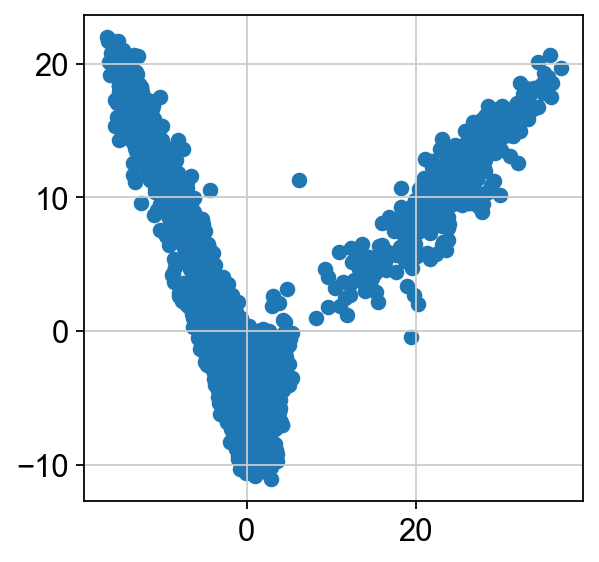

In [37]:
# plot the first and second components against each other
plt.scatter(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1])

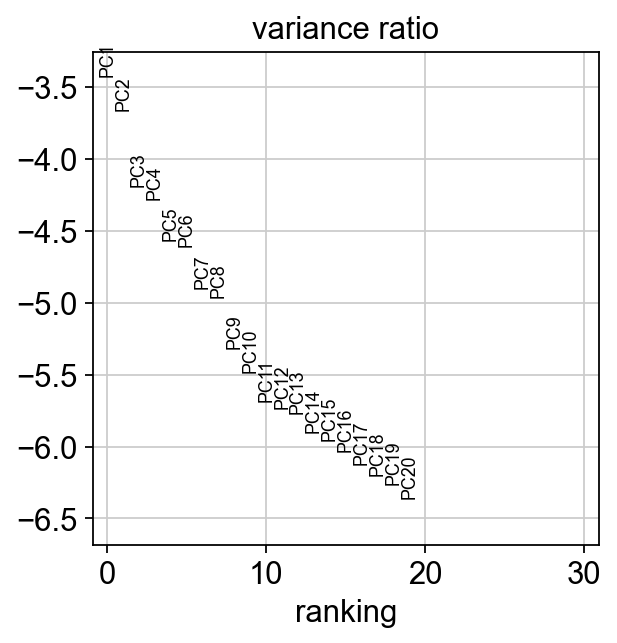

In [38]:
# apply the elbow rule to choose # PCs
# iterate with sc.pp.pca()
sc.pl.pca_variance_ratio(adata, log=True)

### Apply batch correction (BBKNN)

<div class="alert alert-info">
    
***As described in: Polanski et al. (2019), BBKNN: fast batch alignment of single cell transcriptomes [Bioinformatics](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)***
    
</div>

In [39]:
batch_ids = []
for idx_ in adata.obs.index:
    batch_ids.append(idx_.split('-')[2])

In [40]:
adata.obs['batch'] = batch_ids

In [41]:
sc.external.pp.bbknn(adata)

### Leiden clustering

In [42]:
# setting number of neighbors will affect the the leiden clustering
sc.tl.leiden(adata)
# tune resolution so that you can clearly see a reasonable number of clusters for the timepoint
cluster_number = len(adata.obs['leiden'].cat.categories)
print(f'Number of clusters: {cluster_number}')

Number of clusters: 14


### Visualization with UMAP

In [43]:
sc.tl.umap(adata, random_state=1234124) 

/Users/hailey/Dropbox (HMS)/Organoids_shared/ Organoid paper 2021/_THIRD SUBMISSION - MARCH 2021/GSE164638_scRNA-seq/helper_functions_GSE164638.py:321: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[~ix], y[~ix], s=point_size, c=[[.8,.8,.8]], edgecolors = '')
/Users/hailey/Dropbox (HMS)/Organoids_shared/ Organoid paper 2021/_THIRD SUBMISSION - MARCH 2021/GSE164638_scRNA-seq/helper_functions_GSE164638.py:322: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[ix], y[ix], s=point_size, c=[[0,0,0]], edgecolors = '')


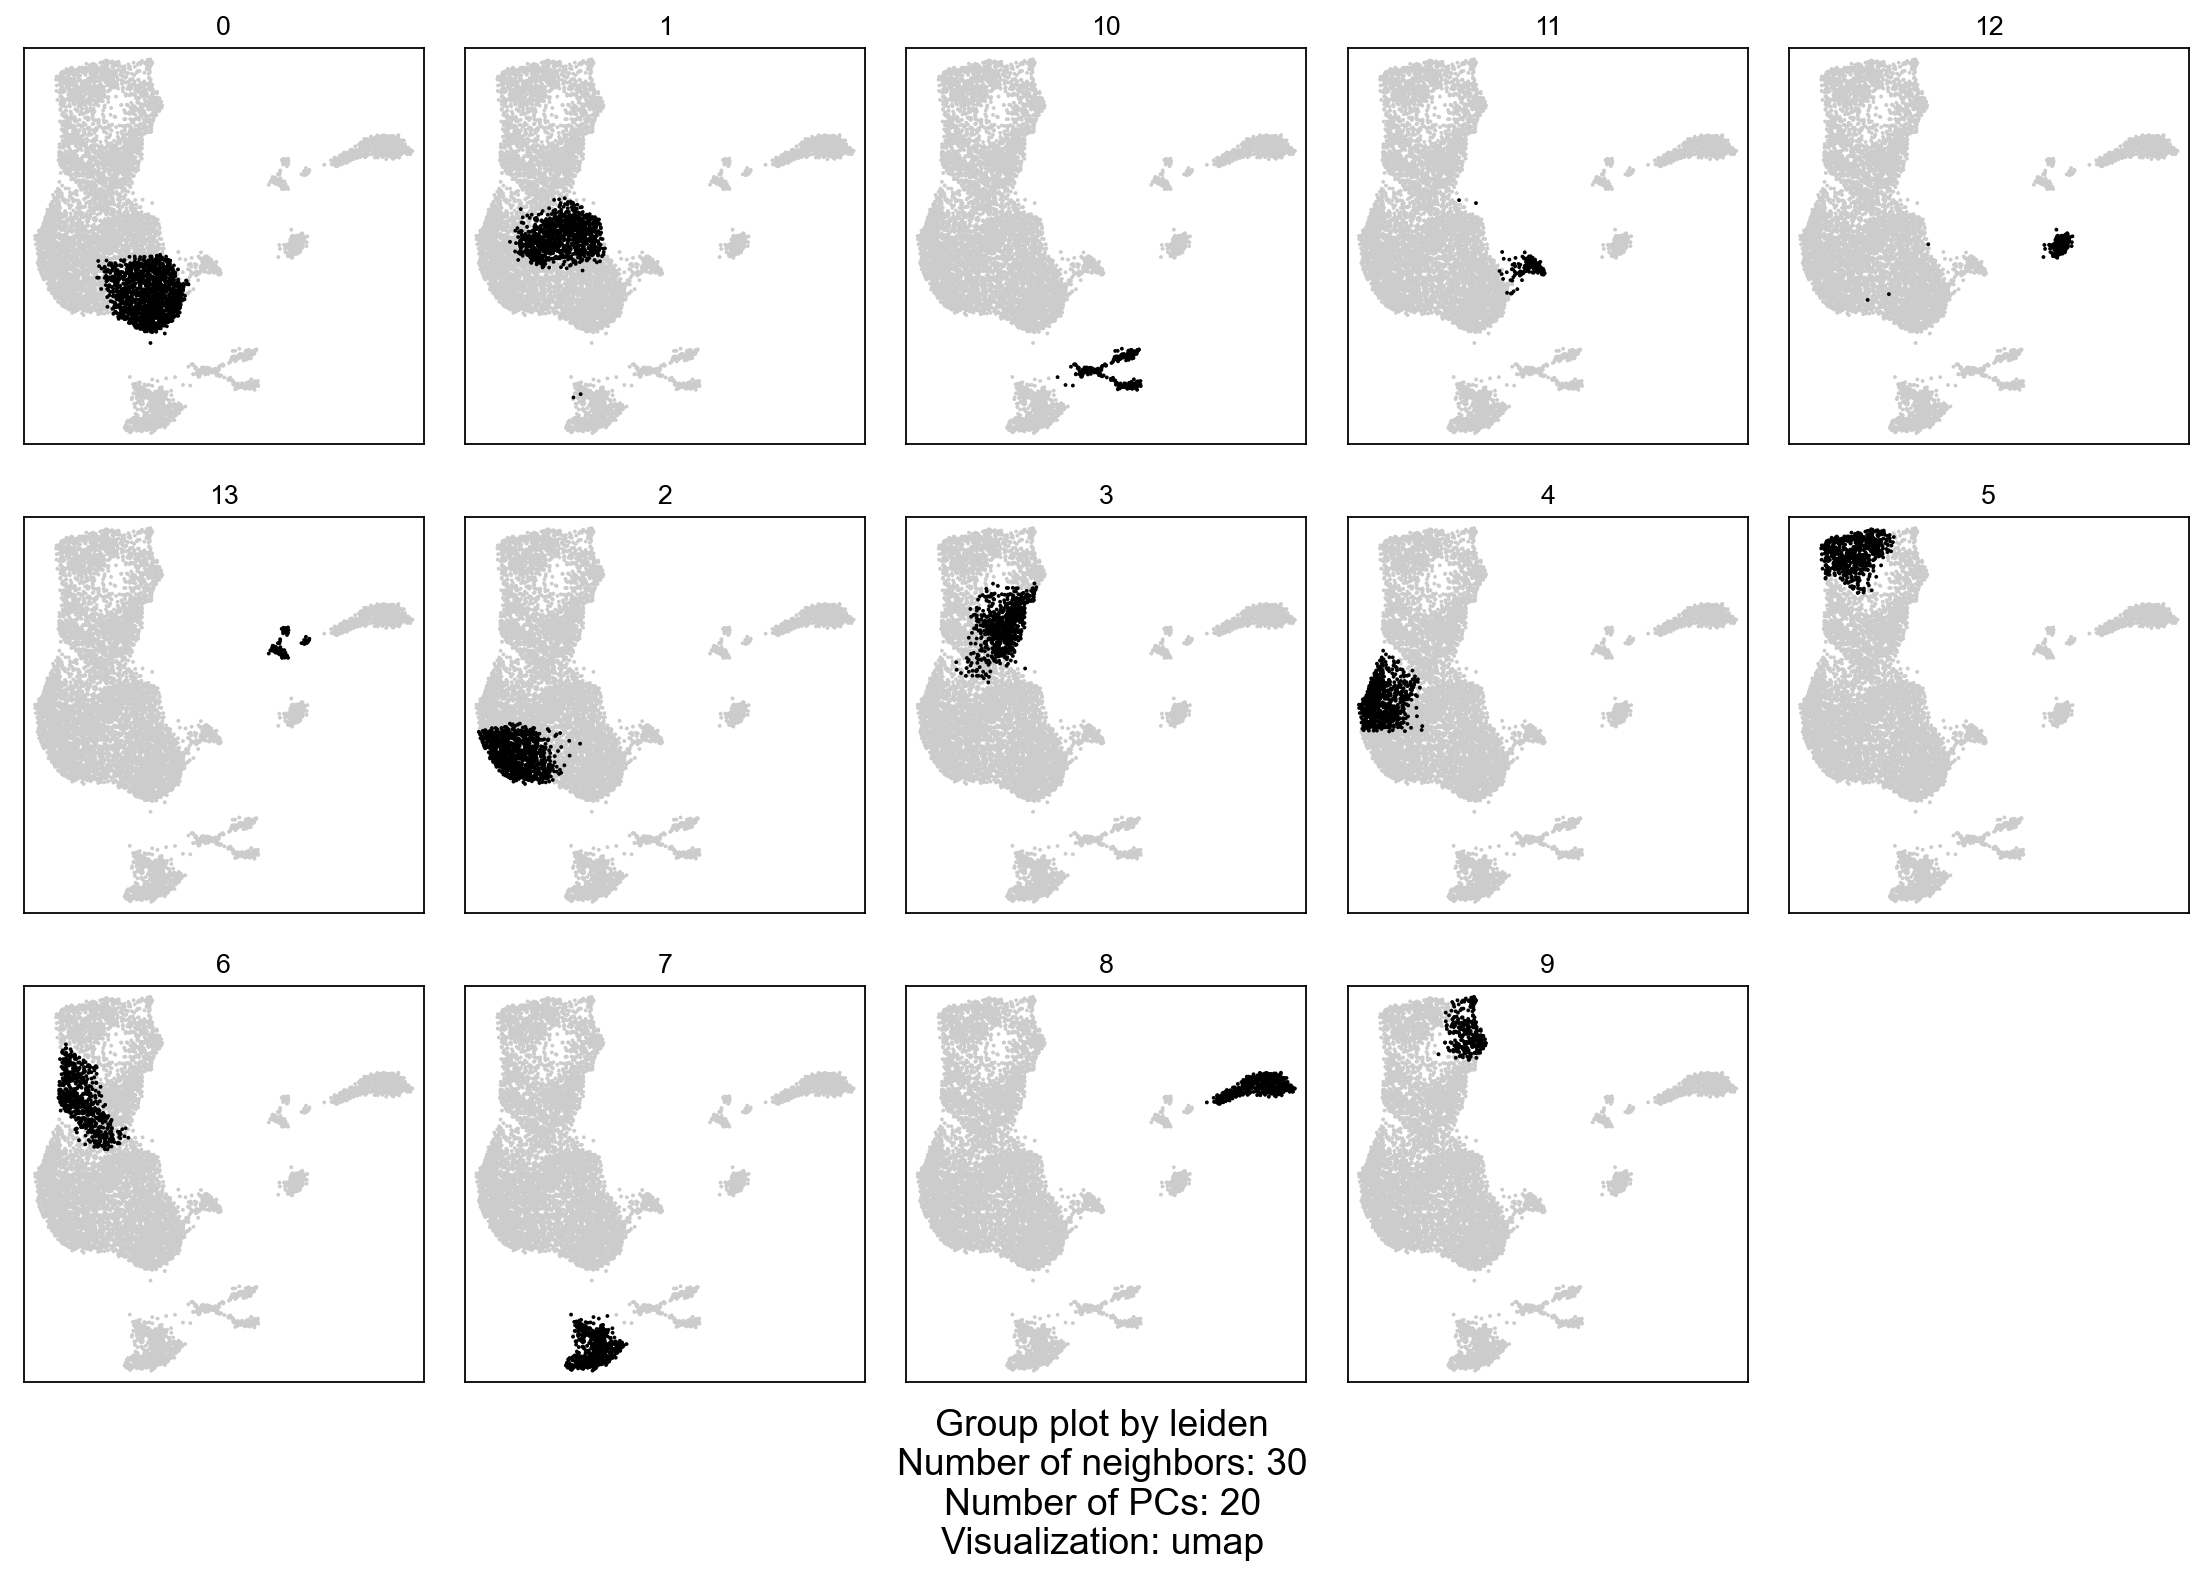

In [44]:
hf.plot_processing(adata, adata.obsm['X_umap'], 'leiden')
plt.show()

... storing 'batch' as categorical


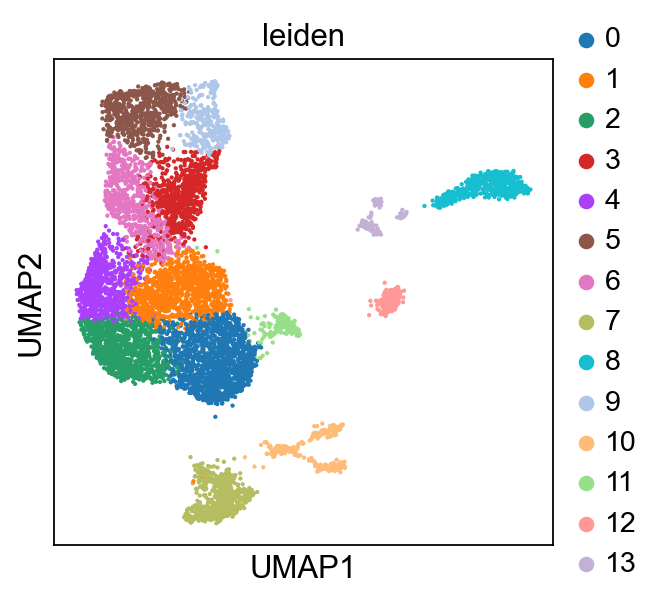

In [45]:
sc.pl.umap(adata, color='leiden')

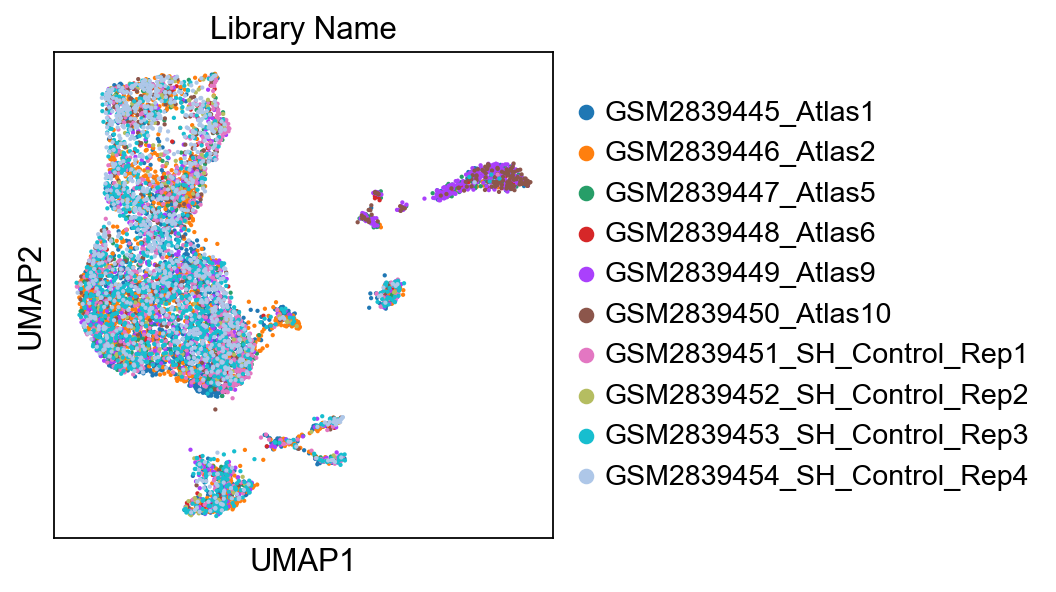

In [46]:
sc.pl.umap(adata, color='Library Name')

*** ***

<a id='annotation'></a>

## Classify states based on marker gene scores

### Load marker genes

In [47]:
#read in differentially expressed genes
df_exp_gene_xl = pd.read_excel('marker_genes_used_for_annotation_no_stretch_signature.xlsx')
# optionally, to include stretch signature annotation replace with: 
#df_exp_gene_xl = pd.read_excel('marker_genes_used_for_annotation.xlsx')

In [48]:
del df_exp_gene_xl['Unnamed: 0'] # added when reading in excel with pandas

In [49]:
# create marker gene dictionary
mg_dict = {}
for state, mg_list in df_exp_gene_xl.items():
    mg_list_cleaned = [x for x in mg_list if str(x) != 'nan' and x in list(adata.var_names)]
    mg_dict[state] = mg_list_cleaned

### Classify states by gene scores

In [50]:
for state, mg_list in mg_dict.items():
    hf.calc_score_denserank(adata, f'state_marker_{state}', mg_dict[f'{state}'][0:100])
hf.classify_gene_score(adata, 'gene_score_state_marker_')

... storing 'classify_gene_score_state_marker_' as categorical


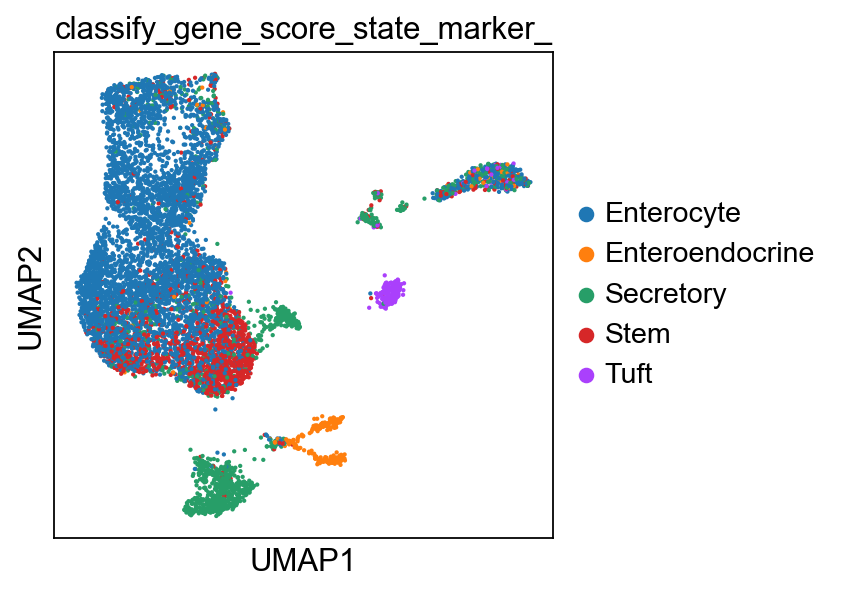

In [51]:
sc.pl.umap(adata, color='classify_gene_score_state_marker_', save='_cbc_score_100mg_cell_states_GSE92332')

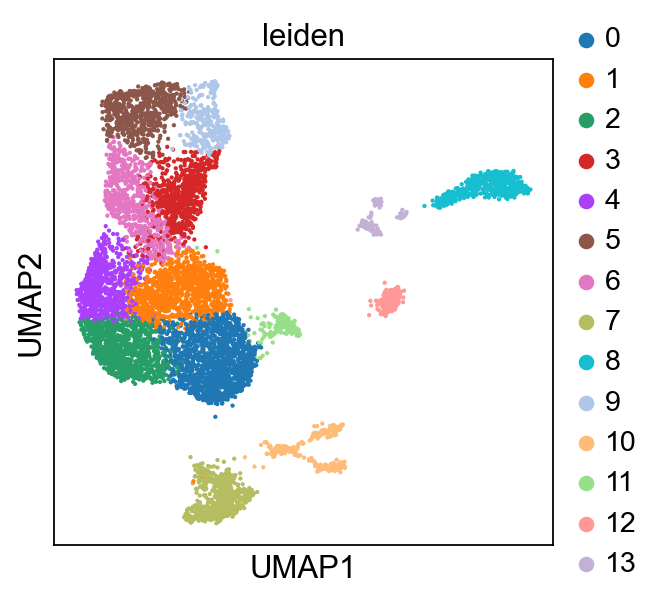

In [52]:
sc.pl.umap(adata, color='leiden')

In [53]:
# remove this cluster as it largely represents one dataset
adata = adata[~adata.obs['leiden'].isin(['8']),:] 

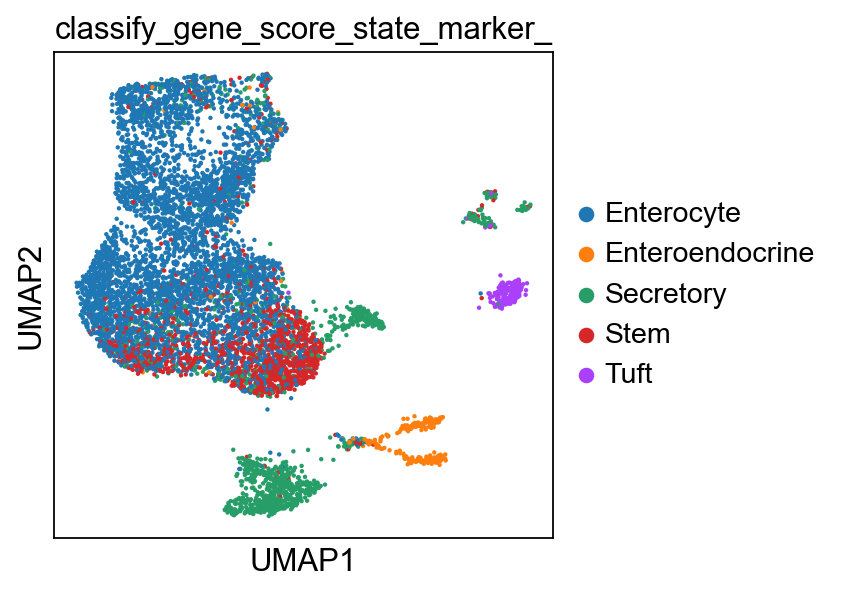

In [54]:
sc.pl.umap(adata, color='classify_gene_score_state_marker_', save='_cbc_score_100mg_cell_states_exc_leiden8_GSE92332')

<a id='coarse_grain'></a>

## Coarse grain annotations based on cluster consensus

In [55]:
# give a more concise name to state label
adata.obs['state'] = adata.obs['classify_gene_score_state_marker_']

Trying to set attribute `.obs` of view, copying.


In [56]:
def coarse_grain_classification(adata, state_group, cluster_group, threshold):
    #this function will coarse grain annotations based on the consensus in the cluster
    #the criteria is that any annotation with less than a fraction (threshold) 
    #of cells in the cluster is replaced with the majority annotation
    #Ex. suggest to use threshold = 0.1
    
    d_dict = {}
    
    n_cat = len(adata.obs[f'{cluster_group}'].cat.categories)
    
    # calculate the fraction of cells in each cluster in each state:
    for cluster in adata.obs[f'{cluster_group}'].cat.categories:
        cl_frac_state = {}
        num_cluster = (adata.obs[f'{cluster_group}'] == f'{cluster}').sum()
        for cat_ in adata.obs[f'{state_group}'].cat.categories:
            num_state = len(adata.obs[adata.obs[f'{cluster_group}'] == f'{cluster}'].loc[adata.obs[f'{state_group}'] == f'{cat_}'])
            cl_frac_state[cat_] = num_state/num_cluster # fraction of cells per state in each cluster
        d_dict[f'{cluster}'] = cl_frac_state
    
    # identify the max annotation per cluster, and annotations less than threshold
    cluster_annot = {}
    cluster_thresh = {}
    for cluster, dict_ in d_dict.items():
        cluster_df = pd.DataFrame.from_dict(dict_, orient='index')
        cluster_annot[cluster] = cluster_df.idxmax()
        cluster_thresh[cluster] = list(cluster_df[cluster_df[0] <= threshold].index)
    
            
    cluster_annot_df = pd.DataFrame.from_dict(cluster_annot)
    cluster_annot_df = cluster_annot_df.transpose()
    cluster_annot_df = cluster_annot_df.rename(columns={0: f'{state_group}'})
    
    #initialize so that the new column has old ids 
    adata.obs['state_coarse_grain'] = adata.obs['state'] #initialize so that the new column has old ids 
    
    for cluster in adata.obs[f'{cluster_group}'].unique():
        for state in cluster_thresh[cluster]:
            adata.obs[f'{state_group}_coarse_grain'].loc[(adata.obs[f'{state_group}'] == state) & \
                                                         (adata.obs[f'{cluster_group}'] == cluster)] \
            = cluster_annot_df[f'{state_group}'][cluster]

In [57]:
coarse_grain_classification(adata, 'state', 'leiden', 0.2)

### Plot the coarse grained cell states

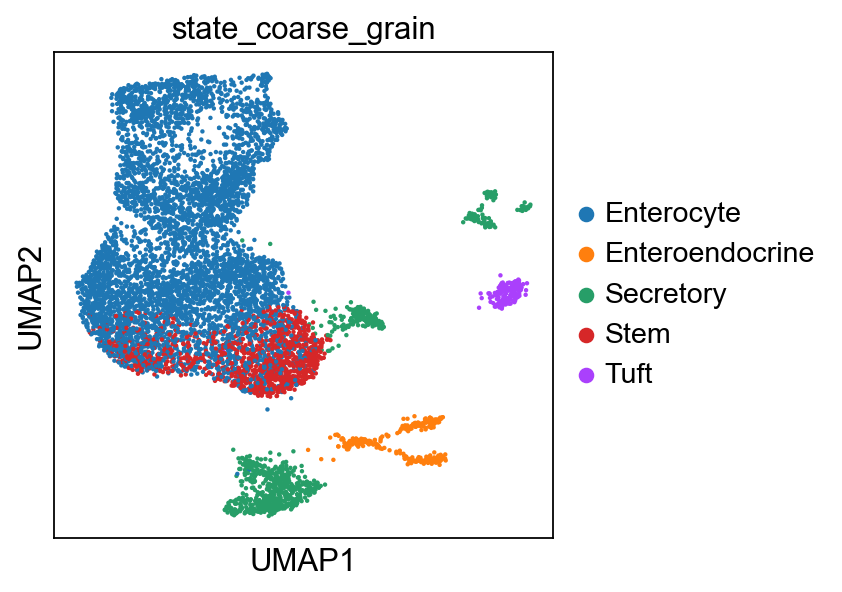

In [58]:
sc.pl.umap(adata, color='state_coarse_grain')

<a id='save_all'></a>

*** ***

<a id='spring'></a>

## Save h5ad file

In [59]:
sc.write(f'{h5ad_dir}/adata_annotated_reference_subset_GSE92332.h5ad', adata)

## Export to SPRING

<div class="alert alert-info">
    
***As described in: Caleb Weinreb, Samuel Wolock, Allon M Klein, SPRING: a kinetic interface for visualizing high dimensional single-cell expression data, Bioinformatics, Volume 34, Issue 7, 01 April 2018, Pages 1246–1248, https://doi.org/10.1093/bioinformatics/btx792***
    
</div>

In [60]:
adata.obs['state'] = adata.obs['state_coarse_grain']

In [63]:
categorical_vars = ['state', 'batch', 'leiden', 'Library Name']
for k in categorical_vars:
    adata.obs[k] = pd.Categorical(adata.obs[k])

In [64]:
adata.obs.columns

Index(['n_counts', 'Library Name', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'percent_mito', 'mito_frac', 'percent_ribo', 'ribo_frac', 'n_genes',
       'batch', 'leiden', 'gene_score_z_state_marker_Enteroendocrine',
       'gene_score_state_marker_Enteroendocrine',
       'gene_score_z_state_marker_Stem', 'gene_score_state_marker_Stem',
       'gene_score_z_state_marker_Tuft', 'gene_score_state_marker_Tuft',
       'gene_score_z_state_marker_Enterocyte',
       'gene_score_state_marker_Enterocyte',
       'gene_score_z_state_marker_Secretory',
       'gene_score_state_marker_Secretory',
       'classify_gene_score_state_marker_', 'state', 'state_coarse_grain'],
      dtype='object')

In [65]:
del adata.raw

In [66]:
#you will need to drag from this folder to the Spring Dev folder in order to actually run it!!
spring_plot_dir = spring_main+'/murine_intestinal_organoid_annotated_reference_subset_GSE92332'
sc.external.exporting.spring_project(
    adata, 
    project_dir=spring_plot_dir, 
    subplot_name='all_cells',
    embedding_method='umap',
    cell_groupings=categorical_vars,
    custom_color_tracks=['gene_score_z_state_marker_Enteroendocrine',
        'gene_score_z_state_marker_Secretory',
        'gene_score_z_state_marker_Stem',
        'gene_score_z_state_marker_Tuft',
       'gene_score_z_state_marker_Enterocyte', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'percent_mito', 'mito_frac',
       'percent_ribo', 'n_genes'],
    overwrite=True
)
#url (after navigating to SPRING_dev): 


Writing subplot to _spring/murine_intestinal_organoid_annotated_reference_subset_GSE92332/all_cells
